In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
import pathlib
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

In [2]:
tf.__version__


'2.13.0'

In [3]:
data_dir = "./Dataset_BUSI_with_GT"
data_dir = pathlib.Path(data_dir)

In [6]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name=='.DS_Store':
                pass
            else:
                r.append(os.path.join(root, name))               
    return r

list_files(data_dir)


['Dataset_BUSI_with_GT/dataset/malignant/malignant (206).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (178).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (197).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (51).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (47).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (181).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (210).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (139).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (10).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (84).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (142).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (115).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (103).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (6).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (154).png',
 'Dataset_BUSI_with_GT/dataset/malignant/malignant (92).png',

In [7]:
def move_images(source, target):
    for root, dirs, files in os.walk(source):
        for file in files:
            if "_mask" in file: 
                os.rename(os.path.join(source,file), os.path.join(target, file))


source_benign='./Dataset_BUSI_with_GT/benign/'
source_normal='./Dataset_BUSI_with_GT/normal/'
source_malignant='./Dataset_BUSI_with_GT/malignant/'

#Create folders to move the masks to
target_benign='./Dataset_BUSI_with_GT/benign_mask/'
target_normal='./Dataset_BUSI_with_GT/normal_mask/'
target_malignant='./Dataset_BUSI_with_GT/malignant_mask/'

#move_images(source_benign, target_benign)
move_images(source_normal, target_normal)
move_images(source_malignant, target_malignant)


In [8]:
# for root, dir, files in os.walk(pathlib.Path(data_dir)):
#     for file in files:
#         if "_mask" in file:
#             os.remove(os.rename(root, file))

In [9]:
data_dir

PosixPath('Dataset_BUSI_with_GT')

In [10]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
dir_list = [os.path.join(data_dir,i) for i in os.listdir(data_dir)]
size_dict = {}
for i,value in enumerate(dir_list):
    if '.DS_Store' in dir_list[i]:
        continue
    else:
        size_dict[os.listdir(data_dir)[i]] = len(os.listdir(value))
size_dict 
    

0


{'dataset': 4, 'masks': 4}

In [11]:
# # Extract the labels and values from the dictionary
# labels = list(size_dict.keys())
# values = list(size_dict.values())

# # Plot the bar chart
# plt.bar(labels, values, tick_label=['({0:d} Normal Tumours)'.format(size_dict["normal"]), 
#                     '({0:d} Benign Samples)'.format(size_dict["benign"]), 
#                     '({0:d} Malignant Samples)'.format(size_dict["malignant"])], 
#         color=['m', 'g', "b"])

# # Add labels and title
# plt.xlabel('Classes')
# plt.ylabel('Count')
# plt.title('Distribution of Classes')

# # Display the plot
# plt.show()

In [13]:
batch_size = 16
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory('./Dataset_BUSI_with_GT/dataset/',
  validation_split=0.2,
  subset="training",
  seed = 125,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 780 files belonging to 3 classes.
Using 624 files for training.


2023-08-02 20:08:16.633923: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-02 20:08:16.633956: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-02 20:08:16.633966: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-02 20:08:16.634022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-02 20:08:16.634053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed = 125,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1578 files belonging to 2 classes.
Using 315 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant', 'normal']


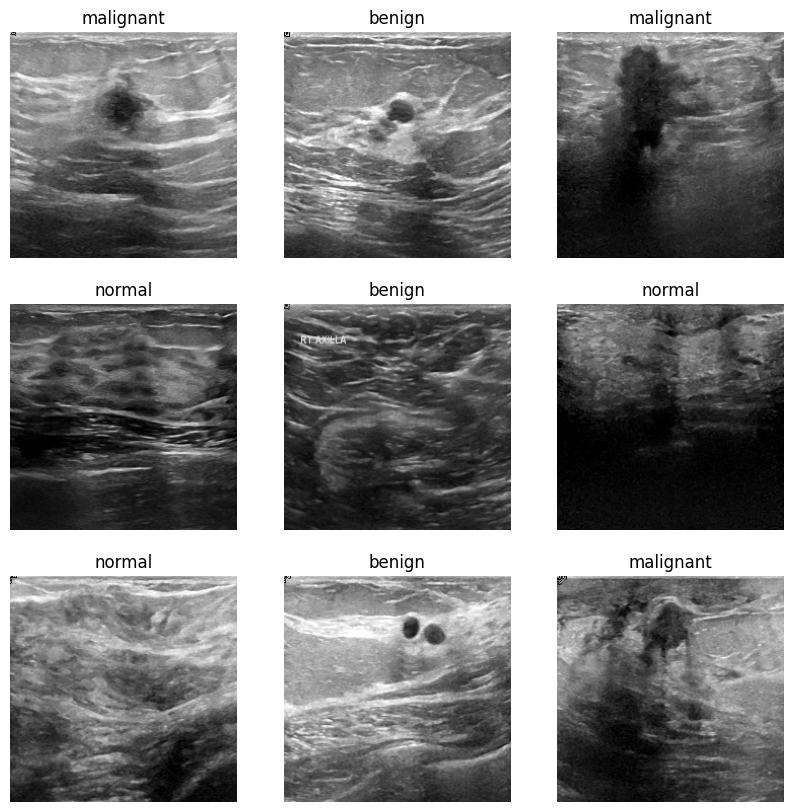

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [18]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

baseModel = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))      

for layer in baseModel.layers:
    layer.trainable = False
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(256,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3)(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = keras.Model(inputs=baseModel.input, outputs=headModel)

model.compile(optimizer='adam',
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])    

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [19]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
# from tensorflow.keras.models import Model

# def resnet_block(inputs, filters, strides=1):
#     # Shortcut branch
#     shortcut = inputs

#     # First convolutional layer
#     x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Second convolutional layer
#     x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)

#     # Shortcut connection
#     if strides != 1:
#         shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
#         shortcut = BatchNormalization()(shortcut)

#     # Add shortcut to the main path
#     x = tf.keras.layers.add([x, shortcut])
#     x = Activation('relu')(x)
#     return x

# def build_resnet(input_shape, num_classes):
#     inputs = Input(shape=input_shape)

#     # Initial convolutional layer
#     x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

#     # Residual blocks
#     x = resnet_block(x, filters=64)
#     x = resnet_block(x, filters=64)
#     x = resnet_block(x, filters=64)

#     x = resnet_block(x, filters=128, strides=2)
#     x = resnet_block(x, filters=128)
#     x = resnet_block(x, filters=128)
#     x = resnet_block(x, filters=128)

#     x = resnet_block(x, filters=256, strides=2)
#     x = resnet_block(x, filters=256)
#     x = resnet_block(x, filters=256)
#     x = resnet_block(x, filters=256)
#     x = resnet_block(x, filters=256)
#     x = resnet_block(x, filters=256)

#     x = resnet_block(x, filters=512, strides=2)
#     x = resnet_block(x, filters=512)
#     x = resnet_block(x, filters=512)

    
#     # Global average pooling and output layer
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)
#     outputs = Dense(num_classes)(x)
#     # outputs = Dense(num_classes, activation='softmax')(x)

#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# # Specify the input shape and number of classes
# input_shape = (512, 512, 3)  # Image size and number of channels
# num_classes = 3  # Number of classes

# # Build the ResNet-based model
# model = build_resnet(input_shape, num_classes)

# # Print the model summary
# model.summary()


In [20]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
#tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
callbacks = [
            tf.keras.callbacks.LearningRateScheduler(scheduler),
            # tf.keras.callbacks.ModelCheckpoint(
            #     filepath='/Users/suyash/DKE/Semester 4/Project/xAI-healthcare/models',
            #     save_best_only=True,
            #     monitor='val_accuracy',
            #     mode='max')
            ]

history=model.fit(
  train_ds,
  validation_data=val_ds,       
  epochs=100,
  verbose=1,
  callbacks=[callbacks]
)

Epoch 1/100


2023-08-02 20:08:28.277129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 5.1539 - accuracy: 0.3798

2023-08-02 20:08:37.507303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 15s 300ms/step - loss: 5.1539 - accuracy: 0.3798 - val_loss: 5.4437 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 11s 268ms/step - loss: 4.8487 - accuracy: 0.3862 - val_loss: 5.0079 - val_accuracy: 0.2825 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 11s 268ms/step - loss: 4.5579 - accuracy: 0.4119 - val_loss: 4.1741 - val_accuracy: 0.3397 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 11s 270ms/step - loss: 4.4849 - accuracy: 0.4006 - val_loss: 3.7694 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 10s 248ms/step - loss: 3.8045 - accuracy: 0.3958 - val_loss: 4.6469 - val_accuracy: 0.1429 - lr: 9.0484e-04
Epoch 6/100
39/39 [==============================] - 10s 246ms/step - loss: 3.8874 - accuracy: 0.3750 - val_loss: 3.5269 - val_accuracy: 0.2413 - lr: 8.1873e-04
Epoch 7/100
39/39 [==============================] - 10s 243ms

In [ ]:
model.save('./models/busi_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


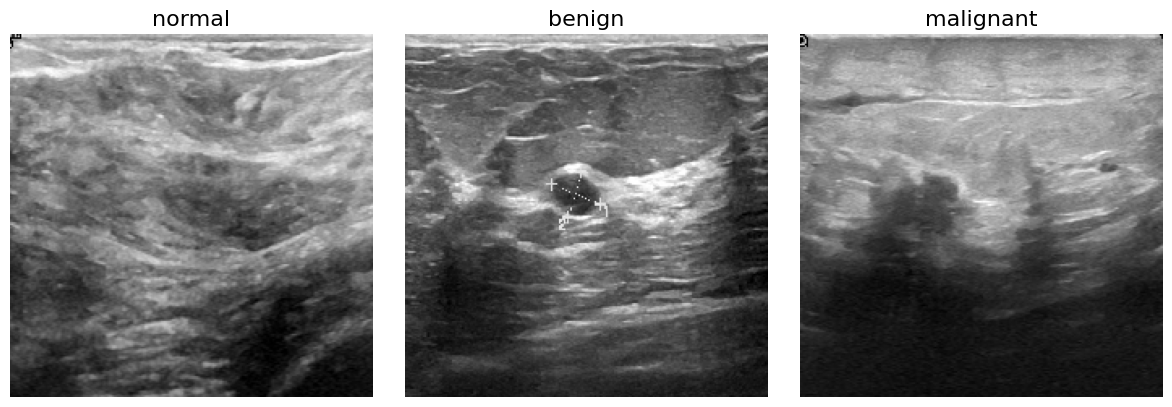

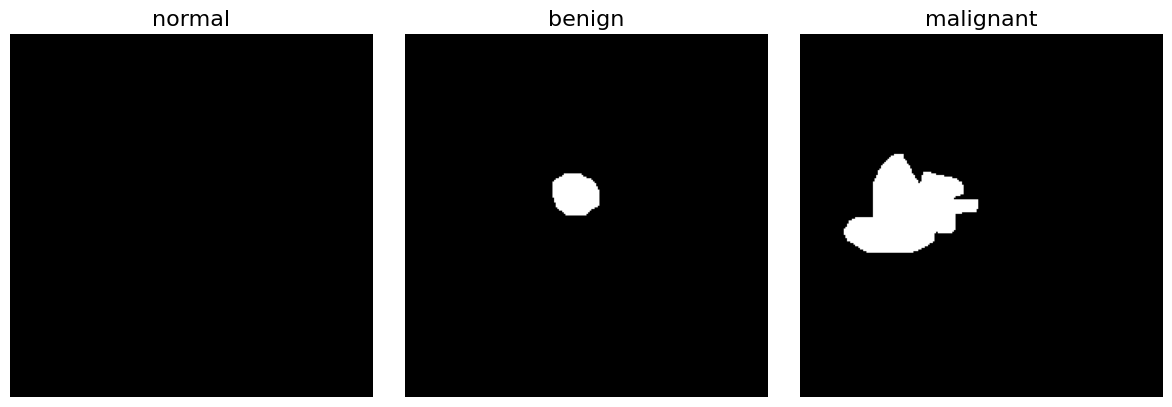

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input

# Image titles
image_titles = ['normal', 'benign','malignant']

path_normal_image='./Dataset_BUSI_with_GT/dataset/normal/normal (5).png'
path_benign_image='./Dataset_BUSI_with_GT/dataset/benign/benign (5).png'
path_malignant_image='./Dataset_BUSI_with_GT/dataset/malignant/malignant (5).png'

path_normal_mask='./Dataset_BUSI_with_GT/masks/normal_mask/normal (5)_mask.png'
path_benign_mask='./Dataset_BUSI_with_GT/masks/benign_mask/benign (5)_mask.png'
path_malignant_mask='./Dataset_BUSI_with_GT/masks/malignant_mask/malignant (5)_mask.png'

# Load images and Convert them to a Numpy array
img1 = load_img(path_normal_image, target_size=(224, 224))
img2 = load_img(path_benign_image, target_size=(224, 224))
img3 = load_img(path_malignant_image, target_size=(224, 224))

mask_normal = load_img(path_normal_mask, target_size=(224, 224))
mask_benign = load_img(path_benign_mask, target_size=(224, 224))
mask_malignant = load_img(path_malignant_mask, target_size=(224, 224))


images = np.asarray([np.array(img1), np.array(img2),np.array(img3)])
masks= np.asarray([np.array(mask_normal), np.array(mask_benign),np.array(mask_malignant)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(masks[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()



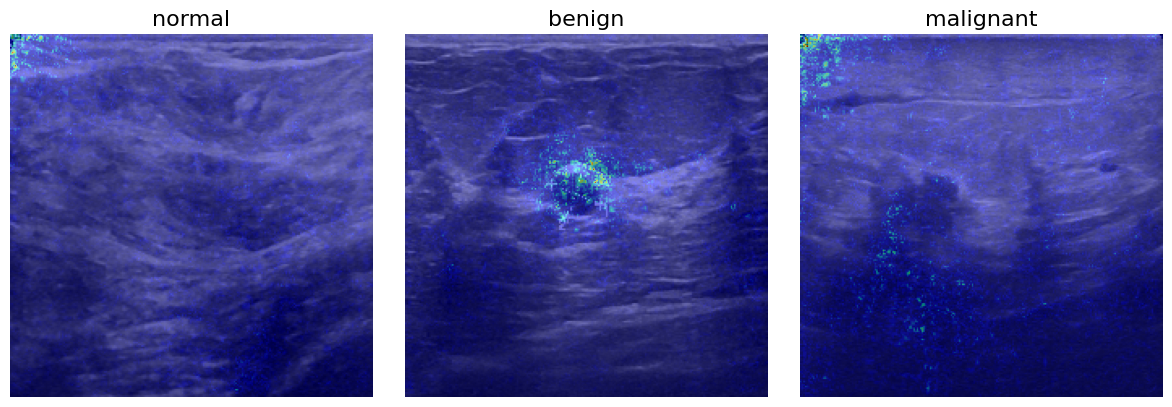

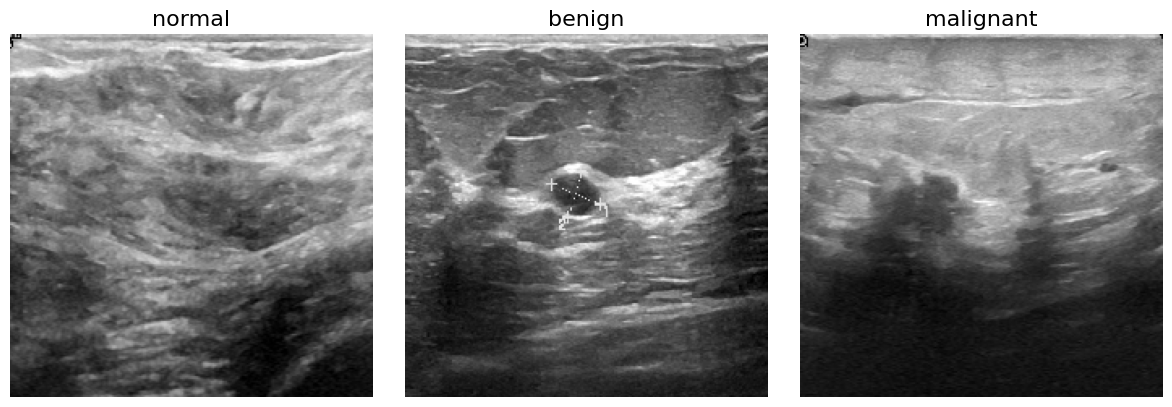

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()
# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1, 2])


from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize



# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].imshow(saliency_map[i], cmap='jet',alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


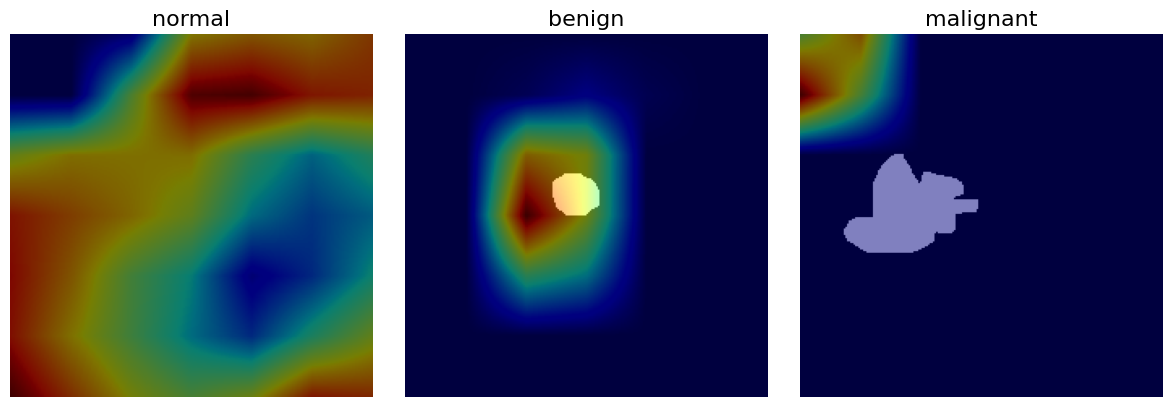

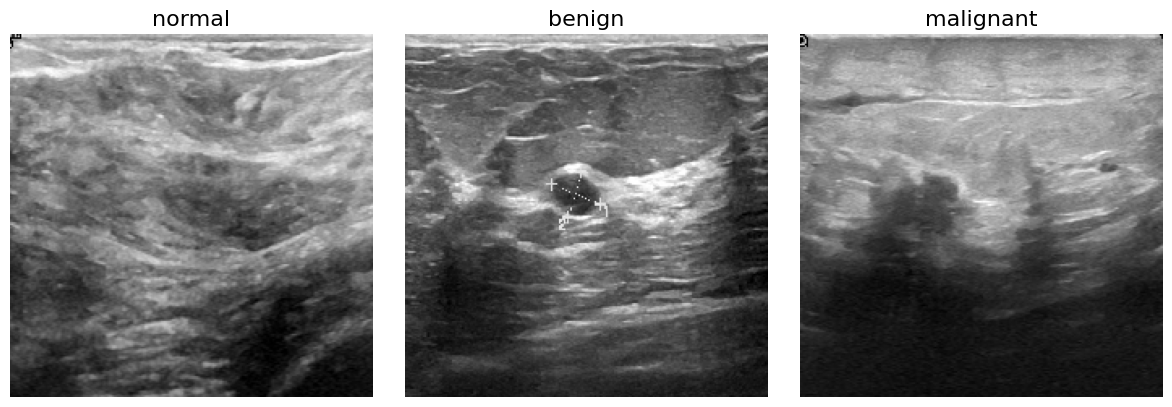

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer='conv5_block3_3_conv')

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(masks[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


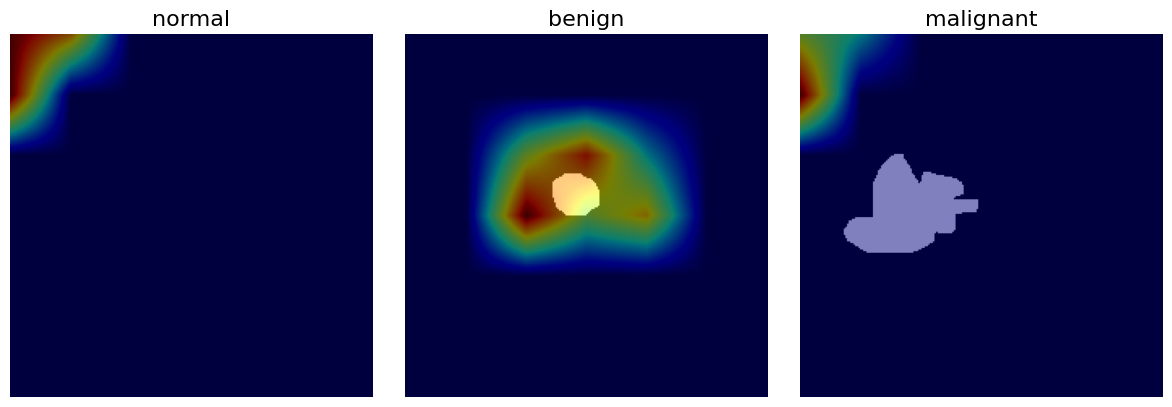

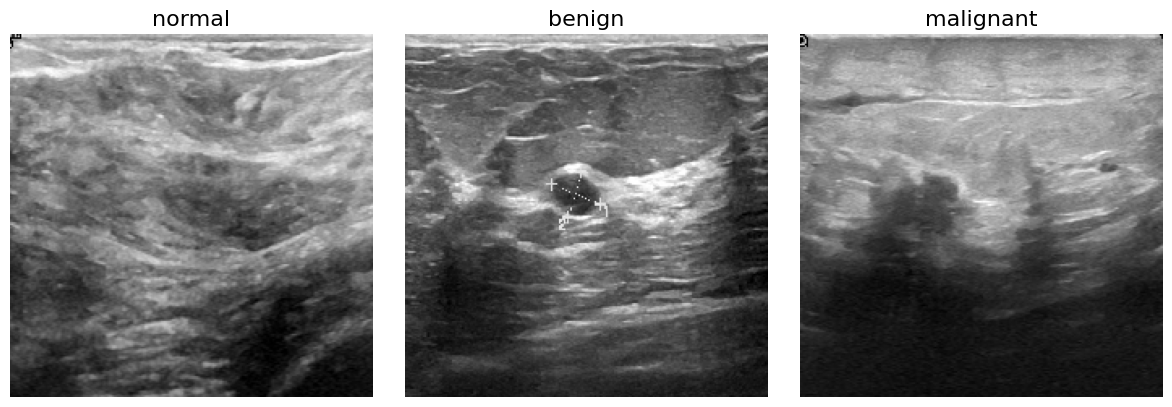

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

gradcam = GradcamPlusPlus(model,
                          model_modifier=ReplaceToLinear(),
                          clone=True)

    # Generate heatmap with GradCAM++
cam = gradcam(score,
                X,
                penultimate_layer='conv5_block3_3_conv')

    # Plot
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(masks[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


2023-07-12 15:41:08.448197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 6s 1s/step


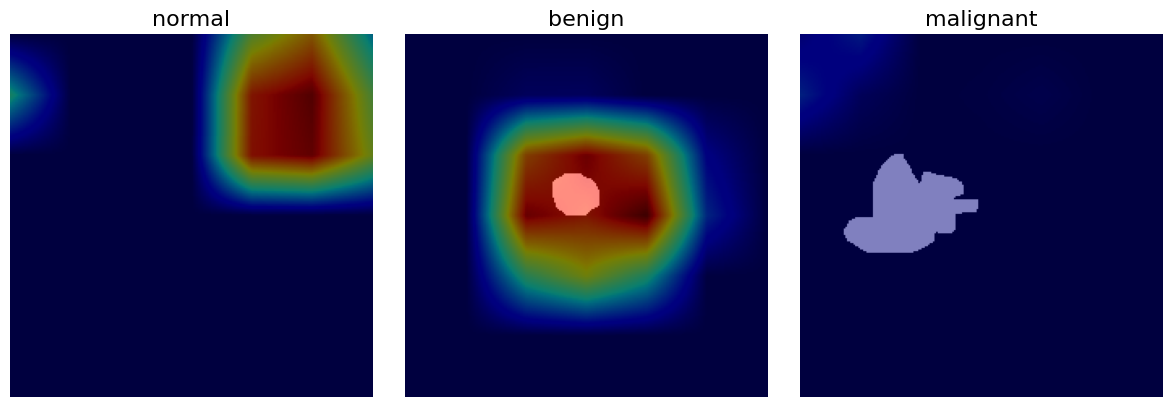

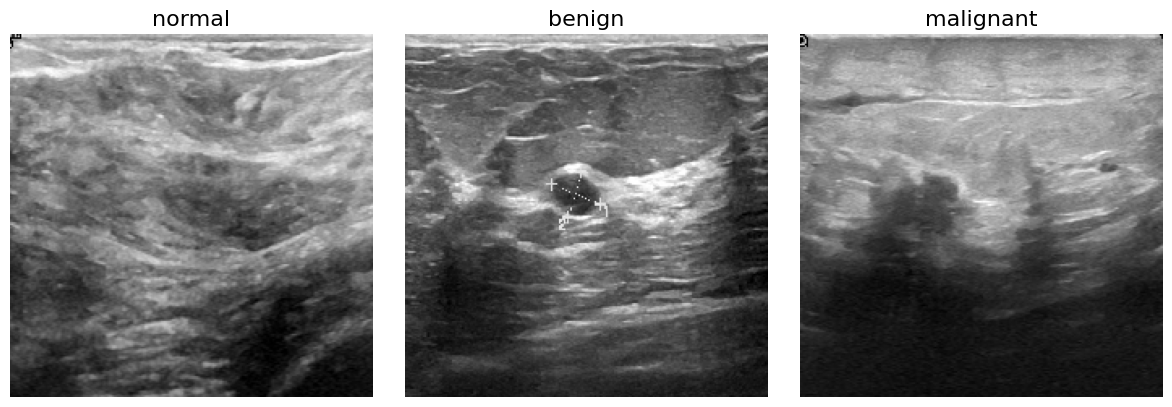

In [ ]:
from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(masks[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [155]:
from lime import lime_image
import time
import cv2
from keras.preprocessing.image import img_to_array, array_to_img

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [156]:
explainer=lime_image.LimeImageExplainer()

In [171]:
normal_image = cv2.imread(path_normal_image)
normal_image = cv2.resize(normal_image, (224,224))
normal_image = img_to_array(normal_image)
normal_image = normal_image / 255.0  # rescaling image
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(normal_image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
print (time.time() - tmp
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 10/1000 [00:00<00:29, 33.77it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 20/1000 [00:00<00:21, 46.06it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 30/1000 [00:00<00:19, 50.77it/s]

1/1 [==============================] - 0s 87ms/step


  4%|▍         | 40/1000 [00:00<00:20, 45.93it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 50/1000 [00:01<00:19, 48.45it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 60/1000 [00:01<00:18, 51.58it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 70/1000 [00:01<00:17, 54.60it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 80/1000 [00:01<00:15, 57.51it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 90/1000 [00:01<00:15, 57.80it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 100/1000 [00:01<00:15, 58.07it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 110/1000 [00:02<00:15, 58.60it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 120/1000 [00:02<00:14, 59.37it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 130/1000 [00:02<00:14, 59.14it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 140/1000 [00:02<00:15, 56.30it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 150/1000 [00:02<00:14, 58.17it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 160/1000 [00:02<00:14, 59.82it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 170/1000 [00:03<00:13, 60.50it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 180/1000 [00:03<00:13, 60.60it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 190/1000 [00:03<00:13, 61.28it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 200/1000 [00:03<00:12, 62.09it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 210/1000 [00:03<00:12, 62.19it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 220/1000 [00:03<00:12, 63.53it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 230/1000 [00:04<00:12, 64.04it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 240/1000 [00:04<00:11, 64.64it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 250/1000 [00:04<00:11, 65.11it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 260/1000 [00:04<00:11, 65.47it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 270/1000 [00:04<00:10, 66.60it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 66.84it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 66.40it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 300/1000 [00:05<00:10, 66.87it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 310/1000 [00:05<00:10, 66.23it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 320/1000 [00:05<00:10, 66.89it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 330/1000 [00:05<00:10, 65.14it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 65.50it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 66.13it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 66.66it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 370/1000 [00:06<00:09, 66.94it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 380/1000 [00:06<00:09, 66.79it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 390/1000 [00:06<00:09, 66.72it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 400/1000 [00:06<00:09, 66.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 410/1000 [00:06<00:08, 67.12it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 67.23it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 430/1000 [00:07<00:08, 66.97it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 440/1000 [00:07<00:08, 67.31it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 450/1000 [00:07<00:08, 67.22it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 66.88it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 470/1000 [00:07<00:08, 66.24it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 480/1000 [00:07<00:07, 66.43it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 66.60it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 500/1000 [00:08<00:07, 66.80it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 510/1000 [00:08<00:07, 67.01it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 520/1000 [00:08<00:07, 67.19it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 530/1000 [00:08<00:06, 67.44it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 540/1000 [00:08<00:06, 67.01it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 550/1000 [00:08<00:06, 66.76it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 66.91it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 570/1000 [00:09<00:06, 66.32it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 580/1000 [00:09<00:06, 66.13it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 66.55it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 600/1000 [00:09<00:05, 66.83it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 610/1000 [00:09<00:05, 66.80it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 65.69it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 630/1000 [00:10<00:05, 65.66it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 640/1000 [00:10<00:05, 65.87it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 650/1000 [00:10<00:05, 66.43it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 660/1000 [00:10<00:05, 65.71it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 670/1000 [00:10<00:05, 60.76it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 680/1000 [00:10<00:05, 57.07it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 690/1000 [00:11<00:05, 53.82it/s]

1/1 [==============================] - 0s 77ms/step


 70%|███████   | 700/1000 [00:11<00:05, 51.24it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 710/1000 [00:11<00:05, 53.25it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 56.29it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 730/1000 [00:11<00:04, 58.78it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 740/1000 [00:11<00:04, 56.99it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 750/1000 [00:12<00:04, 56.79it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 760/1000 [00:12<00:04, 59.98it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 770/1000 [00:12<00:03, 57.77it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 780/1000 [00:12<00:03, 55.03it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 790/1000 [00:12<00:03, 54.57it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 800/1000 [00:13<00:03, 56.80it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 810/1000 [00:13<00:03, 58.59it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 820/1000 [00:13<00:02, 60.65it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 830/1000 [00:13<00:02, 61.69it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 840/1000 [00:13<00:02, 62.06it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 62.41it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 860/1000 [00:13<00:02, 62.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 870/1000 [00:14<00:02, 62.97it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 880/1000 [00:14<00:01, 63.94it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 890/1000 [00:14<00:01, 62.96it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 900/1000 [00:14<00:01, 63.79it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 910/1000 [00:14<00:01, 64.61it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 920/1000 [00:14<00:01, 65.33it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 930/1000 [00:15<00:01, 64.44it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 940/1000 [00:15<00:00, 62.21it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 950/1000 [00:15<00:00, 61.09it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 960/1000 [00:15<00:00, 59.23it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 970/1000 [00:15<00:00, 58.72it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:15<00:00, 59.23it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 990/1000 [00:16<00:00, 59.20it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 1000/1000 [00:16<00:00, 61.58it/s]


16.61546802520752


(-0.5, 223.5, 223.5, -0.5)

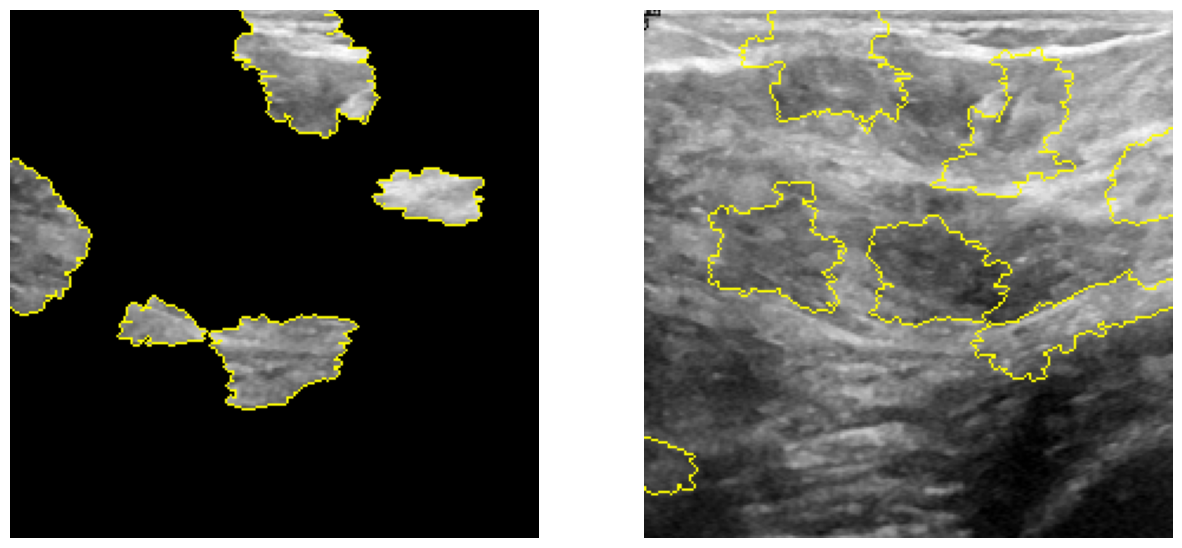

In [172]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True ,negative_only=False, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False ,negative_only=True, num_features=10, hide_rest=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


In [180]:
benign_image = cv2.imread(path_benign_image)
benign_image = cv2.resize(benign_image, (224,224))
benign_image = img_to_array(benign_image)
benign_image = benign_image / 255.0  # rescaling image
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(benign_image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
print (time.time() - tmp)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 10/1000 [00:00<00:15, 63.48it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 20/1000 [00:00<00:14, 66.04it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 30/1000 [00:00<00:14, 66.28it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 40/1000 [00:00<00:14, 66.99it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 50/1000 [00:00<00:14, 67.86it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 60/1000 [00:00<00:13, 67.66it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 70/1000 [00:01<00:13, 67.70it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 80/1000 [00:01<00:13, 67.63it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 90/1000 [00:01<00:13, 67.90it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 100/1000 [00:01<00:14, 61.65it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 110/1000 [00:01<00:15, 58.51it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 120/1000 [00:01<00:14, 59.73it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 130/1000 [00:02<00:14, 60.42it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:02<00:14, 58.58it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 150/1000 [00:02<00:14, 58.91it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 160/1000 [00:02<00:13, 61.59it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 170/1000 [00:02<00:13, 63.18it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 180/1000 [00:02<00:12, 64.89it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 190/1000 [00:02<00:12, 64.82it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 200/1000 [00:03<00:12, 65.67it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 210/1000 [00:03<00:12, 65.23it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 220/1000 [00:03<00:12, 64.35it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 230/1000 [00:03<00:11, 64.37it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 240/1000 [00:03<00:11, 65.33it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 250/1000 [00:03<00:11, 64.60it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 260/1000 [00:04<00:11, 64.39it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 270/1000 [00:04<00:11, 63.41it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 280/1000 [00:04<00:11, 64.39it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 65.27it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 300/1000 [00:04<00:10, 65.28it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 310/1000 [00:04<00:10, 65.31it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 320/1000 [00:04<00:10, 64.75it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 330/1000 [00:05<00:10, 62.80it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 63.63it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 350/1000 [00:05<00:10, 64.19it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 64.90it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 370/1000 [00:05<00:09, 65.36it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 380/1000 [00:05<00:09, 65.93it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 390/1000 [00:06<00:09, 65.14it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 400/1000 [00:06<00:09, 66.22it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 410/1000 [00:06<00:08, 66.82it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 65.44it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 430/1000 [00:06<00:09, 61.86it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 62.60it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 450/1000 [00:07<00:08, 63.53it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 64.56it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 470/1000 [00:07<00:08, 64.97it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 480/1000 [00:07<00:07, 65.62it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 65.34it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 500/1000 [00:07<00:07, 63.11it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 510/1000 [00:07<00:07, 61.65it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 520/1000 [00:08<00:07, 63.52it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 64.82it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 540/1000 [00:08<00:07, 65.15it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 550/1000 [00:08<00:06, 64.29it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 65.23it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 65.62it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 580/1000 [00:09<00:06, 65.57it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 65.48it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 600/1000 [00:09<00:06, 65.77it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 610/1000 [00:09<00:05, 66.26it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 66.16it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 66.49it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 66.73it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 650/1000 [00:10<00:05, 65.47it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 660/1000 [00:10<00:05, 65.03it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 670/1000 [00:10<00:05, 65.33it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 680/1000 [00:10<00:04, 65.83it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 66.13it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 700/1000 [00:10<00:04, 66.47it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 710/1000 [00:10<00:04, 66.72it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 67.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 730/1000 [00:11<00:04, 65.88it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 740/1000 [00:11<00:03, 65.95it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 65.43it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 66.03it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 66.17it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 780/1000 [00:12<00:03, 66.71it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 790/1000 [00:12<00:03, 66.93it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 800/1000 [00:12<00:02, 67.30it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 810/1000 [00:12<00:02, 67.16it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 820/1000 [00:12<00:02, 67.17it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 66.74it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 66.43it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 66.49it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 860/1000 [00:13<00:02, 66.86it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 870/1000 [00:13<00:01, 65.15it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 880/1000 [00:13<00:01, 65.85it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 890/1000 [00:13<00:01, 66.48it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 66.39it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 66.23it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 920/1000 [00:14<00:01, 66.55it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 930/1000 [00:14<00:01, 67.24it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 940/1000 [00:14<00:00, 67.40it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 950/1000 [00:14<00:00, 67.52it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 960/1000 [00:14<00:00, 67.34it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 66.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 980/1000 [00:15<00:00, 66.83it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 990/1000 [00:15<00:00, 65.79it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 1000/1000 [00:15<00:00, 65.16it/s]

15.678759098052979


(-0.5, 223.5, 223.5, -0.5)

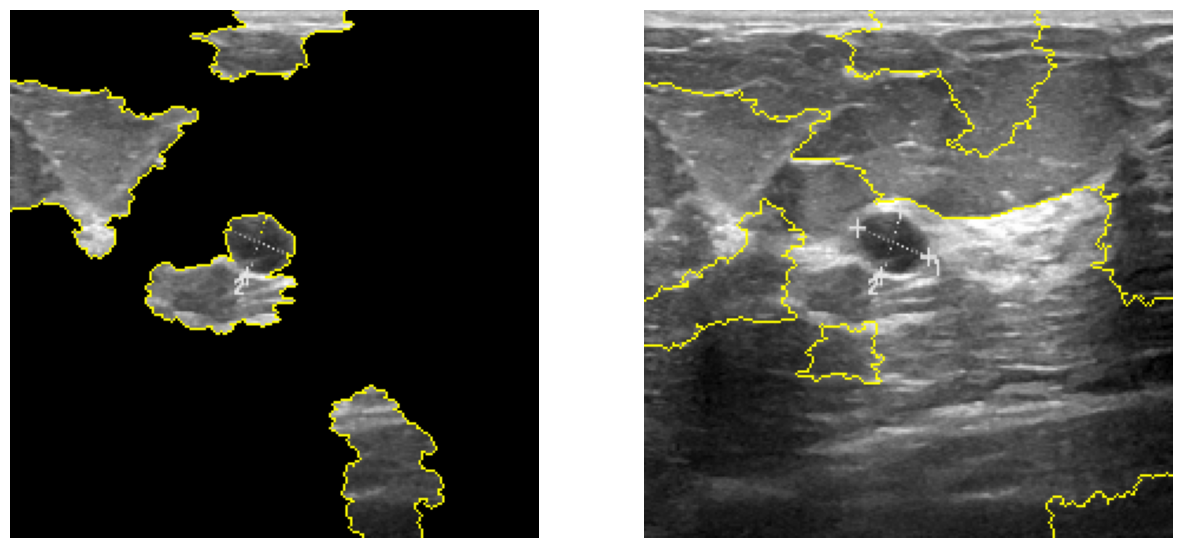

In [181]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True ,negative_only=False, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False ,negative_only=True, num_features=10, hide_rest=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [178]:
malignant_image = cv2.imread(path_malignant_image)
malignant_image = cv2.resize(malignant_image, (224,224))
malignant_image = img_to_array(malignant_image)
malignant_image = malignant_image / 255.0  # rescaling image
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(malignant_image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
print (time.time() - tmp)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  1%|          | 10/1000 [00:00<00:23, 41.25it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 20/1000 [00:00<00:18, 52.28it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 30/1000 [00:00<00:17, 56.89it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 40/1000 [00:00<00:16, 58.62it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 50/1000 [00:00<00:15, 61.40it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 60/1000 [00:01<00:14, 63.25it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 70/1000 [00:01<00:14, 63.73it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 80/1000 [00:01<00:14, 62.55it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 90/1000 [00:01<00:15, 57.39it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 100/1000 [00:01<00:15, 58.21it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 110/1000 [00:01<00:15, 58.71it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 120/1000 [00:02<00:14, 59.50it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 130/1000 [00:02<00:14, 58.35it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 140/1000 [00:02<00:15, 56.82it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 150/1000 [00:02<00:14, 58.31it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 160/1000 [00:02<00:17, 48.34it/s]

1/1 [==============================] - 0s 116ms/step


 17%|█▋        | 170/1000 [00:03<00:20, 41.46it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 180/1000 [00:03<00:18, 43.85it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 190/1000 [00:03<00:17, 47.20it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 200/1000 [00:03<00:15, 51.22it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 210/1000 [00:03<00:15, 52.66it/s]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 220/1000 [00:04<00:17, 44.60it/s]

1/1 [==============================] - 0s 114ms/step


 23%|██▎       | 230/1000 [00:04<00:18, 42.77it/s]

1/1 [==============================] - 0s 128ms/step


 24%|██▍       | 240/1000 [00:04<00:20, 37.09it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 250/1000 [00:04<00:18, 41.35it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 260/1000 [00:05<00:17, 42.81it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 270/1000 [00:05<00:16, 45.35it/s]

1/1 [==============================] - 0s 73ms/step


 28%|██▊       | 280/1000 [00:05<00:16, 43.30it/s]

1/1 [==============================] - 0s 153ms/step


 29%|██▉       | 290/1000 [00:05<00:17, 40.06it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███       | 300/1000 [00:06<00:17, 40.41it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 310/1000 [00:06<00:16, 42.69it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 320/1000 [00:06<00:15, 44.18it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 330/1000 [00:06<00:14, 45.59it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 340/1000 [00:06<00:13, 49.83it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 350/1000 [00:07<00:12, 53.15it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 360/1000 [00:07<00:11, 56.80it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 370/1000 [00:07<00:10, 59.09it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 380/1000 [00:07<00:10, 61.33it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 390/1000 [00:07<00:09, 62.75it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 400/1000 [00:07<00:09, 64.13it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 410/1000 [00:07<00:09, 64.63it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 420/1000 [00:08<00:09, 63.85it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 430/1000 [00:08<00:09, 63.27it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 440/1000 [00:08<00:08, 64.01it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 450/1000 [00:08<00:08, 65.44it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 460/1000 [00:08<00:08, 66.13it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 470/1000 [00:08<00:07, 66.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 480/1000 [00:09<00:07, 67.04it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 490/1000 [00:09<00:07, 67.15it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 500/1000 [00:09<00:07, 66.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 510/1000 [00:09<00:07, 66.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 520/1000 [00:09<00:07, 67.05it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 530/1000 [00:09<00:07, 64.04it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 540/1000 [00:10<00:08, 55.14it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 550/1000 [00:10<00:08, 52.01it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 560/1000 [00:10<00:08, 54.84it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 570/1000 [00:10<00:07, 57.13it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 580/1000 [00:10<00:07, 58.75it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 590/1000 [00:10<00:06, 59.93it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 600/1000 [00:11<00:06, 61.24it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 610/1000 [00:11<00:06, 61.63it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 620/1000 [00:11<00:06, 61.95it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 630/1000 [00:11<00:05, 61.95it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 640/1000 [00:11<00:05, 62.87it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 650/1000 [00:11<00:05, 63.17it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 660/1000 [00:12<00:05, 63.93it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 670/1000 [00:12<00:05, 64.08it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 680/1000 [00:12<00:04, 64.96it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 690/1000 [00:12<00:04, 64.99it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 700/1000 [00:12<00:04, 65.21it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 710/1000 [00:12<00:04, 65.47it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 720/1000 [00:12<00:04, 65.50it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 730/1000 [00:13<00:04, 65.80it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 740/1000 [00:13<00:03, 65.67it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 750/1000 [00:13<00:03, 64.50it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 760/1000 [00:13<00:03, 63.66it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 770/1000 [00:13<00:03, 64.08it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 780/1000 [00:13<00:03, 64.22it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 790/1000 [00:14<00:03, 65.00it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 800/1000 [00:14<00:03, 65.08it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 810/1000 [00:14<00:02, 65.90it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 820/1000 [00:14<00:02, 65.83it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 830/1000 [00:14<00:02, 65.95it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 840/1000 [00:14<00:02, 66.30it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 850/1000 [00:14<00:02, 66.74it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 860/1000 [00:15<00:02, 67.19it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 870/1000 [00:15<00:01, 67.27it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 880/1000 [00:15<00:01, 66.94it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 890/1000 [00:15<00:01, 66.86it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 900/1000 [00:15<00:01, 66.84it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 910/1000 [00:15<00:01, 66.35it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 920/1000 [00:15<00:01, 66.35it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 930/1000 [00:16<00:01, 66.37it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 940/1000 [00:16<00:00, 66.38it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 950/1000 [00:16<00:00, 66.62it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 960/1000 [00:16<00:00, 65.89it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 970/1000 [00:16<00:00, 66.19it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 980/1000 [00:16<00:00, 65.83it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 990/1000 [00:17<00:00, 65.90it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 1000/1000 [00:17<00:00, 58.20it/s]

17.536235094070435


(-0.5, 223.5, 223.5, -0.5)

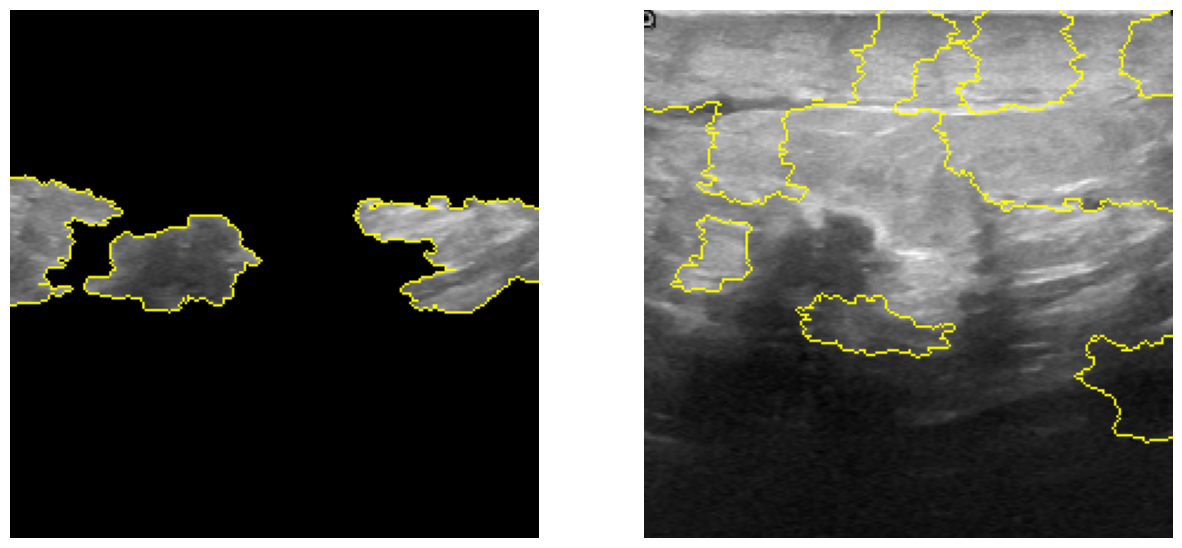

In [179]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True ,negative_only=False, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False ,negative_only=True, num_features=10, hide_rest=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')